### Imports

In [74]:
import struct
import os
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import plotly.io as pio # themes
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

sns.set_style("darkgrid")
sns.set(style='ticks', font_scale=1.3)
sns.set_palette("bright")
plt.rc('font', family='monospace')
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

idx = pd.IndexSlice
bgcolour = "rgb(15, 23, 42)"
plotly_template = pio.templates["plotly_dark"]

# Parameters
G = 2.9599e-4 # gravitational constant [AU^3 / M_solar * days^2]

#### - Data extraction guide

- mass => `mass[i, :]`   - mass of each particle in the snapshot
- pos  => `pos[i, :, :]` - position of each particle in the snapshot
    - x => `pos[i, :, 0]` - x position
    - y => `pos[i, :, 1]` - y position
    - z => `pos[i, :, 2]` - z position
- vel  => `vel[i, :, :]` - velocity of each particle in the snapshot
    - vx => `vel[i, :, 0]` - x velocity
    - vy => `vel[i, :, 1]` - y velocity
    - vz => `vel[i, :, 2]` - z velocity
- acc  => `acc[i, :, :]` - acceleration of each particle in the snapshot
    - ax => `acc[i, :, 0]` - x acceleration
    - ay => `acc[i, :, 1]` - y acceleration
    - az => `acc[i, :, 2]` - z acceleration

... except data manipulation is easier and faster if we pack the data into a dataframe, so we'll do that instead.

```python
mass = df.loc[:,idx[:,'mass']]
x = df.loc[:,idx[:,'x']] # .groupby(level=0, axis=1).sum()
y = df.loc[:,idx[:,'y']]
z = df.loc[:,idx[:,'z']]

fx = df.loc[:,idx[:,'fx']]
fy = df.loc[:,idx[:,'fy']]
fz = df.loc[:,idx[:,'fz']]

vx = df.loc[:,idx[:,'vx']]
vy = df.loc[:,idx[:,'vy']]
vz = df.loc[:,idx[:,'vz']]
```

### Reading & unpacking the binary data file

In [63]:
def process_data(simulation_run_folder):
     
    """
    This code first constructs the path to the out folder for the specific simulation run. It then uses os.listdir to get a list of filenames in the out folder, and filters the list to only include filenames that end with ".bin". The resulting list of snapshot filenames is then sorted, so that the snapshots are processed in order.
    """
     
    snapshot_folder = os.path.join("out", simulation_run_folder)

    snapshot_filenames = []
    for filename in os.listdir(snapshot_folder):
        if filename.endswith(".bin"):
            snapshot_filenames.append(os.path.join(snapshot_folder, filename))

    snapshot_filenames.sort()

    """ 
    This code reads the header data from the binary file - in most cases, we only need to read the first snapshot, since the header data is the same for all snapshots. We will implement a way to read the header data from any snapshot file.
    """

    filename = snapshot_filenames[0]
    with open(filename, 'rb') as f:
        header_dtype = np.dtype([('N', np.int32),
                                ('current_time', np.float32),
                                ('delta_time', np.float32),
                                ('softening_factor', np.float32),])
        
        header = np.frombuffer(f.read(header_dtype.itemsize), header_dtype)

    n_bodies = header['N'][0]
    softening_factor = header['softening_factor'][0]
    total_snapshots = len(snapshot_filenames)

    print("n_bodies: ", n_bodies)
    print("softening_factor: ", softening_factor)
    print("total_snapshots: ", total_snapshots)
    
    """
    This code reads each binary snapshot file in turn using `np.frombuffer`, and returns the data as a numpy array. The data is then reshaped to the correct dimensions, and the mass, position, velocity, and force data is extracted. 
    """

    mass = np.zeros((total_snapshots, n_bodies), dtype=np.float32)
    pos = np.zeros((total_snapshots, n_bodies, 3), dtype=np.float32)
    vel = np.zeros((total_snapshots, n_bodies, 3), dtype=np.float32)
    acc = np.zeros((total_snapshots, n_bodies, 3), dtype=np.float32)
    current_time = np.zeros((total_snapshots,), dtype=np.float32)
    delta_time = np.zeros((total_snapshots,), dtype=np.float32)

    for index, snapshot_filename in enumerate(snapshot_filenames):
        with open(snapshot_filename, "rb") as f:
            header = np.frombuffer(f.read(header_dtype.itemsize), header_dtype)
            current_time[index] = header['current_time'][0]
            delta_time[index] = header['delta_time'][0]

            snapshot = np.frombuffer(f.read(), dtype=np.float32)
            snapshot = snapshot.reshape((n_bodies, 10))

            mass[index, :] = snapshot[:, 0]
            pos[index, :, :] = snapshot[:, 1:4]
            vel[index, :, :] = snapshot[:, 4:7]
            acc[index, :, :] = snapshot[:, 7:10]

    total_time = current_time[-1]
    print(f'total_time: {total_time:.2f} yrs | {total_time/10**6:.4f} Myrs')

    """ 
    This code extracts the mass, position, velocity, and force data from the numpy arrays, and stores it in a pandas DataFrame. The DataFrame is then returned, along with the header data.
    """

    df_list = []
    for i in range(n_bodies):
        data = {
            "mass": mass[:, i],
            "x": pos[:, i, 0],
            "y": pos[:, i, 1],
            "z": pos[:, i, 2],
            "vx": vel[:, i, 0],
            "vy": vel[:, i, 1],
            "vz": vel[:, i, 2],
            "fx": acc[:, i, 0],
            "fy": acc[:, i, 1],
            "fz": acc[:, i, 2],
            "current_time": current_time,
            "delta_time": delta_time
        }
        df_list.append(pd.DataFrame(data))

    df = pd.concat(df_list, axis=1, keys=["{}".format(i) for i in range(n_bodies)])

    """
    This code creates a numpy array that contains the snapshot index and the current time for each snapshot. This array is returned along with the DataFrame, header data, and other useful information.
    """

    snapshot_indices = np.arange(total_snapshots)
    current_time_array = df[("0", "current_time")].values

    time_arr = np.column_stack((snapshot_indices, current_time_array))

    delta_time_arr = df[("0", "delta_time")].values

    return df, time_arr, current_time_array, delta_time_arr, n_bodies, softening_factor, total_snapshots, total_time


### Energy calculation
Here we calculate the total gravitational potential energy and kinetic energy of the system as a whole throughout the simulation.

In [53]:
def systemEnergy(data):
    # Gravitational Potential Energy
    fx, fy, fz = data.loc[:,idx[:,'fx']], data.loc[:,idx[:,'fy']], data.loc[:,idx[:,'fz']]
    fx_sum, fy_sum, fz_sum = fx.cumsum(axis=1), fy.cumsum(axis=1), fz.cumsum(axis=1)
    f_sum = np.sqrt(fx_sum.iloc[:,-1]**2 + fy_sum.iloc[:,-1]**2 + fz_sum.iloc[:,-1]**2)
    gravPotEnergy = 0.5 * (f_sum)

    # Kinetic Energy
    mass = (data.loc[:,idx[:,'mass']]).groupby(level=0, axis=1).sum()
    vx, vy, vz = data.loc[:,idx[:,'vx']], data.loc[:,idx[:,'vy']], data.loc[:,idx[:,'vz']]
    vxSq, vySq, vzSq = vx**2, vy**2, vz**2
    vxSq, vySq = vxSq.align(vySq, fill_value=0)
    vxSq, vzSq = vxSq.align(vzSq, fill_value=0)
    vxSq, vySq = vxSq.align(vySq, fill_value=0)
    vMag = (vxSq + vySq + vzSq).groupby(level=0, axis=1).sum()
    kineticEnergy = (0.5 * mass * vMag**2).cumsum(axis=1).iloc[:,-1]

    print("Gravitational Potential Energy: ", gravPotEnergy.iloc[-1])
    print("Kinetic Energy: ", kineticEnergy.iloc[-1])
    print("Total Energy: ", gravPotEnergy.iloc[-1] + kineticEnergy.iloc[-1])

    return gravPotEnergy, kineticEnergy, gravPotEnergy + kineticEnergy

### Binary Finder

To determine if two stars are gravitationally bound in a binary system, we need to compare the gravitational force between them and compare it to the kinetic energy between them. If the kinetic energy is greater than the gravitational force, then the two stars are gravitationally bound.

In [46]:
def find_bound_pairs(data):
    
    x  = data.loc[:,idx[:,'x']].groupby(level=0, axis=1).sum()
    y  = data.loc[:,idx[:,'y']].groupby(level=0, axis=1).sum()
    z  = data.loc[:,idx[:,'z']].groupby(level=0, axis=1).sum()
    vx = data.loc[:,idx[:,'vx']].groupby(level=0, axis=1).sum()
    vy = data.loc[:,idx[:,'vy']].groupby(level=0, axis=1).sum()
    vz = data.loc[:,idx[:,'vz']].groupby(level=0, axis=1).sum()
    m  = data.loc[:,idx[:,'mass']].groupby(level=0, axis=1).sum()

    is_bound = np.zeros((total_snapshots, n_bodies), dtype=bool)  # Initialize boolean array
    bound_to = [[[] for l in range(n_bodies)] for m in range (total_snapshots)]  # Initialize empty array for 
    pairs = [[]for b in range(total_snapshots)]  # Initialize empty array for pairs
    print(pairs[0])

    for i in range(0, n_bodies - 1):
        for j in range(i + 1, n_bodies):
            # rx = x.iloc[:,j] - x.iloc[:,i]
            # ry = y.iloc[:,j] - y.iloc[:,i]
            # rz = z.iloc[:,j] - z.iloc[:,i]
            # r = np.sqrt(rx**2 + ry**2 + rz**2)
            r1 = np.sqrt(x.iloc[:,i]**2 + y.iloc[:,i]**2 + z.iloc[:,i]**2)
            r2 = np.sqrt(x.iloc[:,j]**2 + y.iloc[:,j]**2 + z.iloc[:,j]**2)

            v1 = np.sqrt(vx.iloc[:,i]**2 + vy.iloc[:,i]**2 + vz.iloc[:,i]**2)
            v2 = np.sqrt(vx.iloc[:,j]**2 + vy.iloc[:,j]**2 + vz.iloc[:,j]**2)
            
            m1, m2 = m.iloc[:,i], m.iloc[:,j]

            # Calculate centre of mass position & velocity
            r_com = (m1 * r1 + m2 * r2) / (m1 + m2)
            v_com = (m1 * v1 + m2 * v2) / (m1 + m2)

            # Apply centre of mass correction to relative position & velocity
            r1 -= r_com; r2 -= r_com
            v1 -= v_com; v2 -= v_com

            # Calculate relative position & velocity
            # r_rel = r2 - r1
            # v_rel = v2 - v1

            # Subtract centre of mass velocity, v_com, from relative velocity, v_rel, 
            # to get relative velocity in the centre of mass frame
            # v_rel_com = v_rel - v_com
            # print(v_rel_com)

            # Calculate the KE & GPE of the system in the centre of mass frame
            # KE = 0.5 * (m1 + m2) * np.dot(v_rel, v_rel)
            # GPE = -G * m1 * m2 / np.linalg.norm(r_rel) # linalg.norm is Euclidean norm
            KE = 0.5 * m1 * v1**2 + 0.5 * m2 * v2**2
            GPE = -G * m1 * m2 / (r1 - r2)**2

            # print(KE)
            # print(GPE)
            

            # force = (G * m1 * m2) / (r**2)
            # kinetic = 0.5 * m1 * v1**2 + 0.5 * m2 * v2**2
            # print(f'{i} | {j}')

            for k in range(0, total_snapshots):
                
                # Check if sum of kinetic and potential energy is negative (bound)
                if KE.iloc[k] + GPE.iloc[k] < 0:
                    # print(f'{i} | {j} {k}')
                    is_bound[k,i] = True
                    is_bound[k,j] = True
                    # bound_to[k][i].append((i, j))
                    # bound_to[k][j].append((i, j))
                    pairs[k].append((i, j))

                # if force.iloc[k] > kinetic.iloc[k]: # bound
                #     print(f'{i} | {j} {k}')
                #     is_bound[k,i] = True
                #     is_bound[k,j] = True
                #     bound_to[k][i].append((i, j))
                #     bound_to[k][j].append((i, j))
                #     pairs[k].append((i, j))
    
    # Add is_bound and bound_to columns to dataframe
    for i in range(0, n_bodies):
        data[f'{i}', 'bound'] = is_bound[:,i]
        # data[f'{i}', 'bound_to'] = [bound_to[k][i] for k in range(total_iterations)]
    # Add pairs column to dataframe
    data['pairs'] = pairs

    return data 

#### - Data retrieval 

In [64]:
df, time_arr, current_time_arr, delta_time_arr, n_bodies, softening_factor, total_snapshots, total_time = process_data("n-10-cluster")
GPE, KE, totalE = systemEnergy(df)
df = find_bound_pairs(df)

n_bodies:  10
softening_factor:  0.000125
total_snapshots:  5760
total_time: 5820591.00 yrs | 5.8206 Myrs
Gravitational Potential Energy:  3.0856094e-07
Kinetic Energy:  1.8534160586323228e-09
Total Energy:  3.1041435818913035e-07
[]


### Plotting the data

##### - Plotting the binary stars

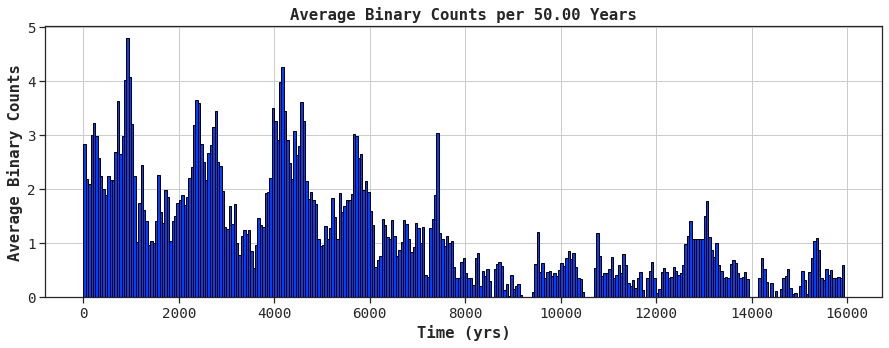

In [76]:
binary_counts = df['pairs'].apply(lambda row: sum(1 for _ in row))

# Set data
step_time = 50.0 # in years
x_data = current_time_arr / 365.25
y_data = binary_counts

# Calculate the number of bins
total_time = x_data[-1] - x_data[0]
num_bins = int(np.ceil(total_time / step_time))

# Calculate the bin edges
bin_edges = np.linspace(x_data[0], x_data[-1], num_bins + 1)

# Calculate the bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Calculate the bin values
bin_values, _ = np.histogram(x_data, bins=bin_edges, weights=binary_counts)

# Divide by the actual bin width to get the average
bin_widths = np.diff(bin_edges)
bin_values = np.array(bin_values, dtype=float)
bin_values /= bin_widths

# Create bar plot using matplotlib
# plt.style.use('bmh')
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax.bar(bin_centers, bin_values, width=step_time, edgecolor='black')
ax.grid(True)

# Set labels and title
ax.set_xlabel('Time (yrs)')
ax.set_ylabel('Average Binary Counts')
ax.set_title(f'Average Binary Counts per {step_time:.2f} Years')

# Show the plot
plt.show()

In [ ]:
# bound = (df.loc[:,idx[:,'bound']] == True).groupby(level=0, axis=1).sum()
# bound_pairs = (df.loc[:,idx[:,'bound_to']])
# bound_pairs = df[df.loc[:,idx[:,'bound']].any(axis=1)]  # filter to only include rows where any body is bound
# bound_pairs.loc[:,idx[:, ['x']]].plot()
##### **Energy of System**

In [68]:
print(delta_time_arr.shape)
print(current_time_arr.shape)

(5760,)
(5760,)


2.7116173708319134e-07


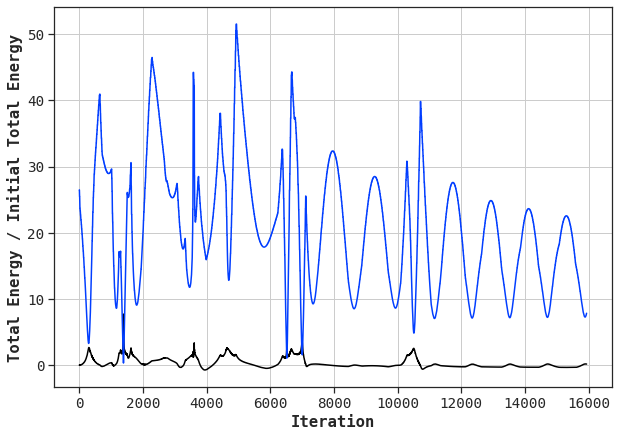

In [79]:
# Create plot environment
# plt.style.use('bmh')
fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.grid(True)

# Variable setting
# x_data = np.arange(0, total_);
x_data = current_time_arr / 365.25
y_data = ((totalE - totalE[0]) / totalE[0]) 

# Plot graph
plt.plot(x_data, y_data, color="black", label="$\mathrm{E}_{\mathrm{total}}$ change");
plt.plot(x_data,delta_time_arr)
# plt.title("Total Energy Change")
plt.xlabel("Iteration");
plt.ylabel("Total Energy / Initial Total Energy")
print(totalE[0])

**Energy Conservation**

In [51]:
# plt.plot(current_time_arr)
# print(time_arr.shape)

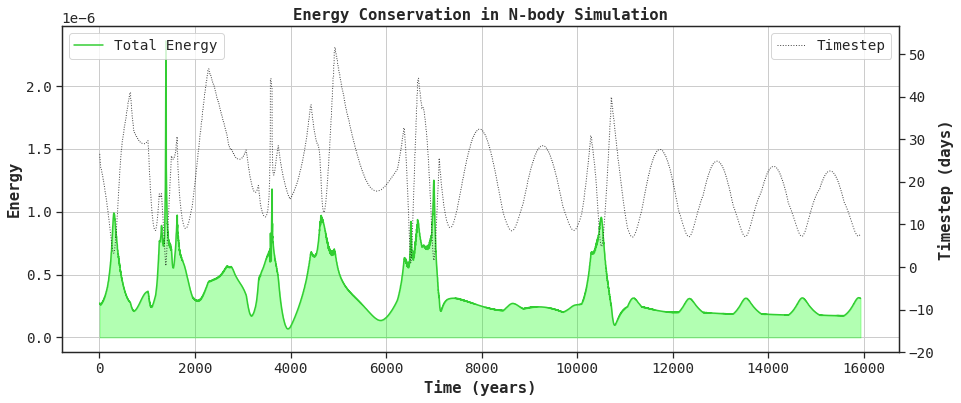

In [161]:
# Set data
x_data = current_time_arr / 365.25
y_data_gpe = GPE
y_data_ke = KE
# y_data = ((totalE - totalE[0]) / totalE[0]) 
y_data_total = ((totalE - totalE[0]) / totalE[0])
y_data_dt = delta_time_arr

# Create the plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
ax.grid(True)

# Plot the data
# plt.plot(x_data, y_data_gpe, label='Gravitational Potential Energy (GPE)', linestyle='-', marker='.')
# plt.plot(x_data, y_data_ke, label='Kinetic Energy (KE)', linestyle='-', marker='o')
ax.plot(x_data, y_data_total, label='Total Energy', linestyle='-', color='limegreen', linewidth=1.5)

# Set labels and title
ax.set_xlabel('Time (years)')
ax.set_ylabel('Energy')
ax.set_title('Energy Conservation in N-body Simulation')

# Create a second y-axis for the timestep
ax2 = ax.twinx()

# Set the y-axis limits
ax2.set_ylim(-20, max(y_data_dt) + 5)

# Plot the timestep data on the secondary y-axis
ax2.plot(x_data, y_data_dt, label='Timestep', linestyle=':', color='black', alpha=0.7, linewidth=1)

# Set the ylabel for the secondary y-axis
ax2.set_ylabel('Timestep (days)')

# Fill the area under the Total Energy curve
ax.fill_between(x_data, 0, y_data_total, alpha=0.3, color='lime')
# ax2.fill_between(x_data, 0, y_data_dt, alpha=0.2)

# Add a legend & show the plot
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

##### 3D Plot

In [ ]:
plt.close()
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
# fig.gca(projection="3d")
# ax = Axes3D(fig)
ax.dist = 12
ax.set_xlabel('Position, x (AU)')
ax.set_ylabel('Position, y (AU)')
ax.set_zlabel('Position, z (AU)')

for i in range(0, n_bodies):
    x_data = df[f'{i}']['x']
    y_data = df[f'{i}']['y']
    z_data = df[f'{i}']['z']

    ax.plot3D(x_data, y_data, z_data)
# plt.show()

In [ ]:
print(np.clip(0.1, 1, 2))

##### 3D Interactive Plot

In [72]:
# Dataset
iteration_step = 100
data=[go.Scatter3d( x=df.loc[::iteration_step, idx[f'{i}', 'x']], # retrieves every n'th row
                    y = df.loc[::iteration_step, idx[f'{i}', 'y']], 
                    z = df.loc[::iteration_step, idx[f'{i}', 'z']],
                    mode = 'lines',
                    name = f'Body {i}',
                    line = dict(
                        width = np.clip(2*df[f'{i}']['mass'][0], 1, 10),
                        colorscale='Viridis'
                        ))
                    for i in range(n_bodies)]

# Layout
zoom = 1.2
axis_range = [2000,2000,2000] # [x, y, z]
slider_step=50

layout = go.Layout(
    title='N-Body Simulation',
    autosize=False,
    height=900,
    width=1200,
    template=plotly_template,
    scene=dict(
        aspectratio=go.layout.scene.Aspectratio(x=zoom, y=zoom, z=zoom),
        xaxis=dict(
            showgrid=False,
            range=[-axis_range[0], axis_range[0]],
            autorange=False,
        ),
        yaxis=dict(
            showgrid=False,
            range=[-axis_range[1], axis_range[1]],
            autorange=False,
        ),
        zaxis=dict(
            showgrid=False,
            range=[-axis_range[2], axis_range[2]],
            autorange=False,
        ),
    ),
)

fig = go.Figure(data=data, layout=layout)

fig.show()

# import plotly.offline as plotoff
# plotoff.plot(fig, filename='nbody.html')
# pio.write_html(fig, file='nbody.html', auto_open=True)

# testing

In [ ]:
iteration_step = 10000

data = []
for t in range(0, df.index[-1]+1, iteration_step):
    frame = go.Scatter3d(x=[], y=[], z=[], mode='lines')
    for i in range(n_bodies):
        frame.x.append(df.loc[t, idx[f'{i}', 'x']])
        frame.y.append(df.loc[t, idx[f'{i}', 'y']])
        frame.z.append(df.loc[t, idx[f'{i}', 'z']])
        frame.line.width.append(2 * df[f'{i}']['mass'][0])
    data.append(frame)

# Layout
zoom = 1.2
axis_range = 10000
layout = go.Layout(
    title='N-Body Simulation',
    autosize=False,
    height=900,
    width=1400,
    scene=dict(
        aspectratio=go.layout.scene.Aspectratio(x=zoom, y=zoom, z=zoom),
        xaxis=dict(
            showgrid=False,
            range=[-axis_range, axis_range],
            autorange=False,
        ),
        yaxis=dict(
            showgrid=False,
            range=[-axis_range, axis_range],
            autorange=False,
        ),
        zaxis=dict(
            showgrid=False,
            range=[-axis_range, axis_range],
            autorange=False,
        ),
    ),
    updatemenus=[
        dict(
            type='buttons',
            showactive=False,
            buttons=[
                dict(
                    label='Play',
                    method='animate',
                    args=[None, dict(frame=dict(duration=50, redraw=False),
                                     fromcurrent=True,
                                     transition=dict(duration=0),
                                     mode='immediate'
                                     )
                          ]
                ),
                dict(
                    label='Pause',
                    method='animate',
                    args=[[None], dict(mode='immediate',
                                       transition=dict(duration=0),
                                       frame=dict(duration=0, redraw=False),
                                       mode='immediate'
                                       )]
                )
            ]
        ),
    ],
    sliders=[
        dict(
            active=0,
            currentvalue=dict(prefix="Timestep: "),
            steps=[dict(method='animate',
                        args=[[f'frame{k}'],
                              dict(mode='immediate',
                                   frame=dict(duration=100, redraw=False),
                                   transition=dict(duration=0)
                                   )
                          ],
                        label=f'{k * iteration_step}'
                        )
                   for k in range(0, int((df.index[-1]+1) / iteration_step))
],
),
]
)


fig = go.Figure(data=data, layout=layout)

fig.update_layout(
    updatemenus=[dict(type='buttons', showactive=False, buttons=[dict(label='Play', method='animate', args=[None, dict(frame=dict(duration=50, redraw=False), fromcurrent=True, transition=dict(duration=0), mode='immediate')]), dict(label='Pause', method='animate', args=[[None], dict(mode='immediate', transition=dict(duration=0), frame=dict(duration=0, redraw=False), mode='immediate')])])])
fig.update_layout(sliders=[dict(active=0, currentvalue=dict(prefix="Timestep: "), steps=[dict(method='animate', args=[[f'frame{k}'], dict(mode='immediate', frame=dict(duration=100, redraw=False), transition=dict(duration=0))], label=f'{k * iteration_step}') for k in range(0, int((df.index[-1]+1) / iteration_step))])])
fig.show()

In [ ]:
print(x.shape)
print(x.iloc[0])

In [ ]:
# print(df[::2])
# print x position for each body every 100 timesteps
# print(df.loc[::100, idx[:, 'x']])
# print x position for body i every 100 timesteps
i=4
print(df.loc[::100, idx[f'{i}', 'x']])

In [ ]:

# Dataset
iteration_step = 100
data=[go.Scatter3d( x=df.loc[::iteration_step, idx[f'{i}', 'x']], # this only retrieves every iteration_step'th row
                    y=df.loc[::iteration_step, idx[f'{i}', 'y']], 
                    z=df.loc[::iteration_step, idx[f'{i}', 'z']],
                    mode='lines',
                    name=f'Body {i}',
                    line=dict(
                        width=2*df[f'{i}']['mass'][0],
                        colorscale='Viridis'
                        ))
                    # line=dict(width=2*df[f'{i}']['mass'][0], color='blue'))
                    for i in range(n_bodies)]


    
# make a slider to go forward and backward in time
steps = []
for i in range(0, total_iterations, iteration_step):
    step = dict(
        method="animate",
        args=[
            [i],
            dict(
                frame=dict(duration=0, redraw=True),
                mode="immediate",
                transition=dict(duration=0),
            ),
        ],
        label=f"{i}",
    )
    steps.append(step)

sliders = [
    dict(
        active=0,
        currentvalue={"prefix": "Iteration: "},
        pad={"t": 50},
        steps=steps,
    )
]

# layout["sliders"] = sliders
# Layout
zoom = 1.2
axis_range = 10000
layout = go.Layout(
    title='N-Body Simulation',
    autosize=False,
    height=900,
    width=1400,
    template=plotly_template,
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(
                    label="Play",
                    method="animate",
                    args=[
                        None,
                        dict(
                            frame=dict(duration=0, redraw=True),
                            fromcurrent=True,
                            transition=dict(duration=0),
                            mode="immediate",
                        ),
                    ],
                ),
                dict(
                    label="Pause",
                    method="animate",
                    args=[
                        [None],
                        dict(
                            frame=dict(duration=0, redraw=True),
                            mode="immediate",
                            transition=dict(duration=0),
                        ),
                    ],
                ),
            ],
        )
    ],
    sliders=sliders,
    scene=dict(
        aspectratio=go.layout.scene.Aspectratio(x=zoom, y=zoom, z=zoom),
        xaxis=dict(
            showgrid=False,
            range=[-axis_range, axis_range],
            autorange=False,
        ),
        yaxis=dict(
            showgrid=False,
            range=[-axis_range, axis_range],
            autorange=False,
        ),
        zaxis=dict(
            showgrid=False,
            range=[-axis_range, axis_range],
            autorange=False,
        ),
    ),
)

# now make the slider animate the data
# frames = []
# for i in range(0, total_iterations, iteration_step):
#     frame = dict(
#         data=[go.Scatter3d( x=df.loc[i, idx[f'{j}', 'x']], # this only retrieves every iteration_step'th row
#                             y=df.loc[i, idx[f'{j}', 'y']], 
#                             z=df.loc[i, idx[f'{j}', 'z']],
#                             mode='lines',
#                             name=f'Body {j}',
#                             line=dict(
#                                 width=2*df[f'{j}']['mass'][0],
#                                 colorscale='Viridis'
#                                 ))
#                             # line=dict(width=2*df[f'{j}']['mass'][0], color='blue'))
#                             for j in range(n_bodies)],
#         traces=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
#         name=f"{i}",
#     )
#     frames.append(frame)

# fig = go.Figure(data=data, layout=layout, frames=frames)


fig = go.Figure(data=data, layout=layout, frames=frames)
# fig.update_layout(template=plotly_template)
# fig.update_layout(yaxis_range=[-1, 1])

# fig.update_layout(

# )

fig.show()

# import plotly.offline as plotoff
# plotoff.plot(fig, filename='nbody.html')
# pio.write_html(fig, file='nbody.html', auto_open=True)

In [ ]:
i=1
xf = df.loc[::iteration_step, idx[f'{i}', 'x']]
# print(xf[,0])
xf.shape
# print first 10 values in xf
print(xf[0:10])

In [ ]:
# # Dataset
# data=[go.Scatter3d(x=df[f'{i}']['x'], 
#                     y=df[f'{i}']['y'], 
#                     z=df[f'{i}']['z'],
#                     mode='lines',
#                     name=f'Body {i}',
#                     line=dict(
#                         width=2*df[f'{i}']['mass'][0],
#                         colorscale='Viridis'
#                         ))
#                     # line=dict(width=2*df[f'{i}']['mass'][0], color='blue'))
#                     for i in range(n_bodies)]

# # Layout
# zoom = 1.2

# layout = go.Layout(
#     title='N-Body Simulation',
#     autosize=False,
#     height=900,
#     width=1400,
#     scene=dict(
#         aspectratio=go.layout.scene.Aspectratio(x=zoom, y=zoom, z=zoom)
#         ),
# )
    
# fig = go.Figure(data=data, layout=layout)
# fig.update_layout(template=plotly_template)
# fig.show()

